In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [22]:
dataset_path = 'datasets'

device = torch.device("mps")
batch_size = 128
img_size = (32,32)

input_dim = 3
hidden_dim = 512
latent_dim = 16
n_embeddings = 512
output_dim = 3
commitment_beta = 0.25
lr = 2e-4
epochs = 20
print_step = 10


In [23]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

cifar10_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = CIFAR10(root=dataset_path, train=True, transform=cifar10_transform, download=True)
test_dataset = CIFAR10(root=dataset_path, train=False, transform=cifar10_transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=(4,4,3,1), stride=2):
        super(Encoder, self).__init__()
        kernel_1 , kernel_2 , kernel_3 , kernel_4 = kernel_size
        
        self.strided_conv_1 = nn.Conv2d(input_dim, hidden_dim, kernel_1, stride=stride, padding=1)
        self.strided_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, stride=stride, padding=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_3, padding=1)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_4, padding=0)
        
        self.proj = nn.Conv2d(hidden_dim, output_dim, kernel_size=1)
    
    def forward(self, x):
        x = self.strided_conv_1(x)
        x = self.strided_conv_2(x)
        
        x = F.relu(x)
        
        y = self.residual_conv_1(x)
        y = y+x
        
        x = F.relu(x)
        y = self.residual_conv_2(x)
        y = y+x
        
        y = self.proj(y)
        return y

In [25]:
class VQEmbeddingEMA(nn.Module):
    def __init__(self, n_embeddings, embedding_dim, commitment_cost=0.25, decay=0.999, epsilon=1e-5):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon
        
        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        return quantized, indices.view(x.size(0), x.size(1))
    
    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)
        
        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)
        
        distances = (-torch.cdist(x_flat, self.embedding, p=2)) ** 2

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)
        
        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = (self.ema_count + self.epsilon) / (n + M * self.epsilon) * n

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

In [26]:
class Decoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_sizes=(1, 3, 2, 2), stride=2):
        super(Decoder, self).__init__()
        
        kernel_1, kernel_2, kernel_3, kernel_4 = kernel_sizes
        
        self.in_proj = nn.Conv2d(input_dim, hidden_dim, kernel_size=1)
        
        self.residual_conv_1 = nn.Conv2d(hidden_dim, hidden_dim, kernel_1, padding=0)
        self.residual_conv_2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_2, padding=1)
        
        self.strided_t_conv_1 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_3, stride, padding=0)
        self.strided_t_conv_2 = nn.ConvTranspose2d(hidden_dim, output_dim, kernel_4, stride, padding=0)
        
    def forward(self, x):

        x = self.in_proj(x)
        
        y = self.residual_conv_1(x)
        y = y+x
        x = F.relu(y)
        
        y = self.residual_conv_2(x)
        y = y+x
        y = F.relu(y)
        
        y = self.strided_t_conv_1(y)
        y = self.strided_t_conv_2(y)
        
        return y

In [27]:
class Model(nn.Module):
    def __init__(self, Encoder, Codebook, Decoder):
        super(Model, self).__init__()
        self.encoder = Encoder
        self.codebook = Codebook
        self.decoder = Decoder
                
    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        
        return x_hat, commitment_loss, codebook_loss, perplexity

In [28]:
encoder = Encoder(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=latent_dim)
codebook = VQEmbeddingEMA(n_embeddings=n_embeddings, embedding_dim=latent_dim)
decoder = Decoder(input_dim=latent_dim, hidden_dim=hidden_dim, output_dim=output_dim)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(device)

In [29]:
from torch.optim import Adam

mse_loss = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=lr)


In [30]:
print("Start training VQ-VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        
        loss =  recon_loss + commitment_loss * commitment_beta + codebook_loss
                
        loss.backward()
        optimizer.step()
        
        if batch_idx % print_step ==0: 
            print("epoch:", epoch + 1, "(", batch_idx + 1, ") recon_loss:", recon_loss.item(), " perplexity: ", perplexity.item(), 
              " commit_loss: ", commitment_loss.item(), "\n\t codebook loss: ", codebook_loss.item(), " total_loss: ", loss.item(), "\n")
    
print("Finish!!")

Start training VQ-VAE...
epoch: 1 ( 1 ) recon_loss: 0.335075318813324  perplexity:  23.96602439880371  commit_loss:  0.0009924403857439756 
	 codebook loss:  0.0039697615429759026  total_loss:  0.3392931818962097 

epoch: 1 ( 11 ) recon_loss: 0.061877768486738205  perplexity:  31.484724044799805  commit_loss:  0.0027447952888906 
	 codebook loss:  0.0109791811555624  total_loss:  0.07354315370321274 

epoch: 1 ( 21 ) recon_loss: 0.03754613548517227  perplexity:  44.6302604675293  commit_loss:  0.007072257809340954 
	 codebook loss:  0.028289031237363815  total_loss:  0.0676032304763794 

epoch: 1 ( 31 ) recon_loss: 0.030157586559653282  perplexity:  46.15999221801758  commit_loss:  0.017538536339998245 
	 codebook loss:  0.07015414535999298  total_loss:  0.1046963632106781 

epoch: 1 ( 41 ) recon_loss: 0.02951200306415558  perplexity:  48.85386657714844  commit_loss:  0.03177245706319809 
	 codebook loss:  0.12708982825279236  total_loss:  0.164544939994812 

epoch: 1 ( 51 ) recon_loss

In [31]:
import matplotlib.pyplot as plt

In [32]:
def draw_sample_image(x, postfix):
    plt.figure(figsize=(10, 10))
    plt.title("Visualization of {}".format(postfix))
    plt.imshow(np.transpose(make_grid(x.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))

model.eval()

with torch.no_grad():

    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):

        x = x.to(device)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
 
        print("perplexity: ", perplexity.item(),"commit_loss: ", commitment_loss.item(), "  codebook loss: ", codebook_loss.item())
        break

  0%|          | 0/79 [00:00<?, ?it/s]

perplexity:  411.3523864746094 commit_loss:  0.02736808732151985   codebook loss:  0.1094723492860794


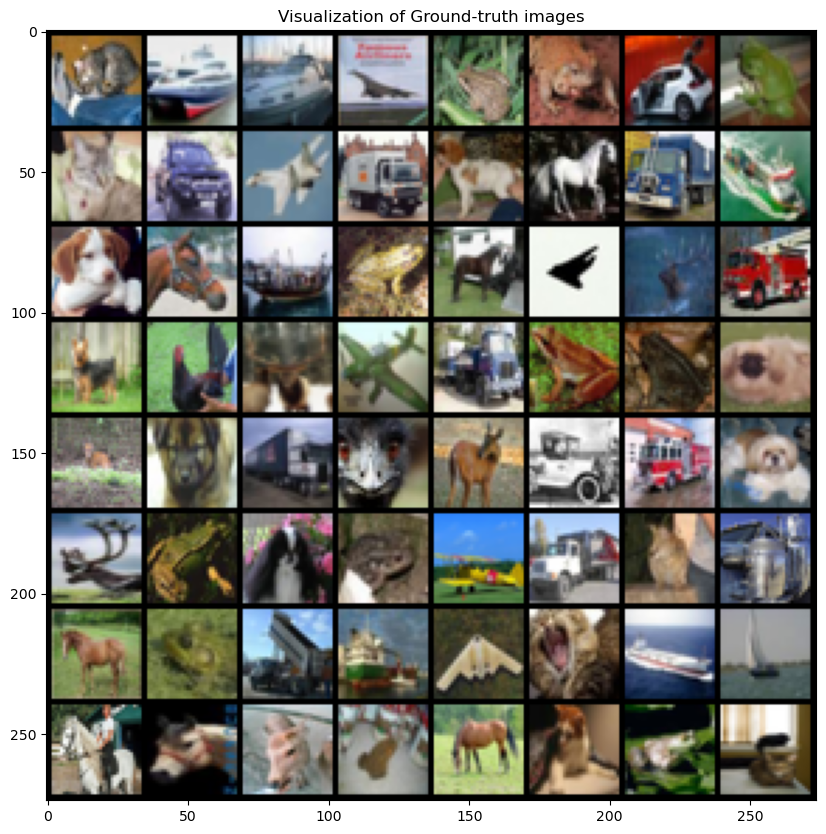

In [33]:
draw_sample_image(x[:batch_size//2], "Ground-truth images")


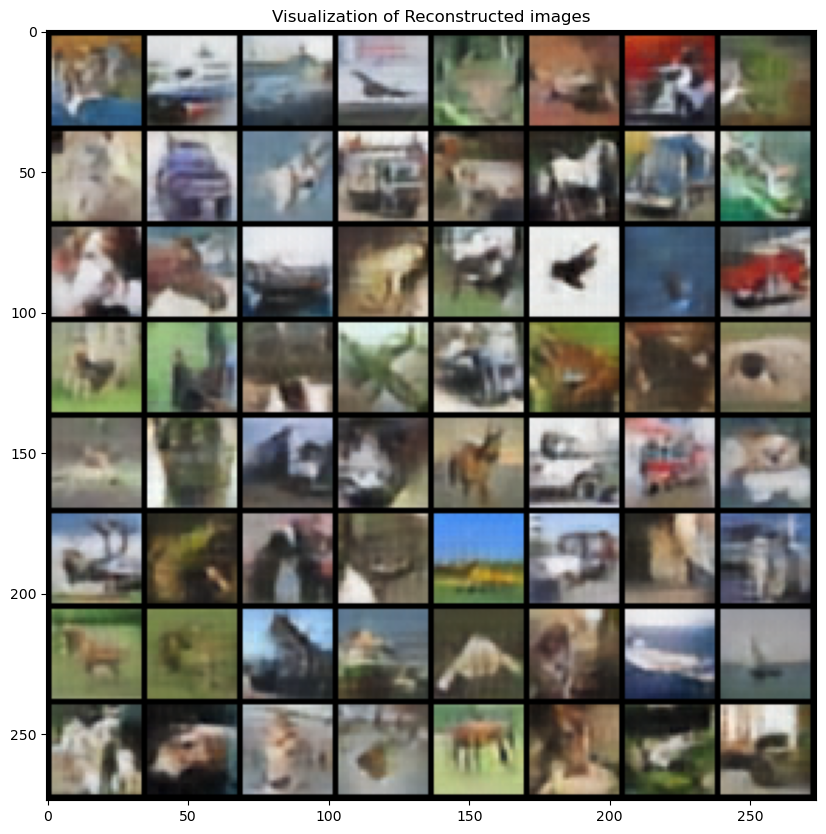

In [34]:
draw_sample_image(x_hat[:batch_size//2], "Reconstructed images")


In [38]:
def draw_random_sample_image(codebook, decoder, indices_shape):
    
    random_indices = torch.floor(torch.rand(indices_shape) * n_embeddings).long().to(device)
    codes = codebook.retrieve_random_codebook(random_indices)
    x_hat = decoder(codes.to(device))
    
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("Visualization of Random Codes")
    plt.imshow(np.transpose(make_grid(x_hat.detach().cpu(), padding=2, normalize=True), (1, 2, 0)))


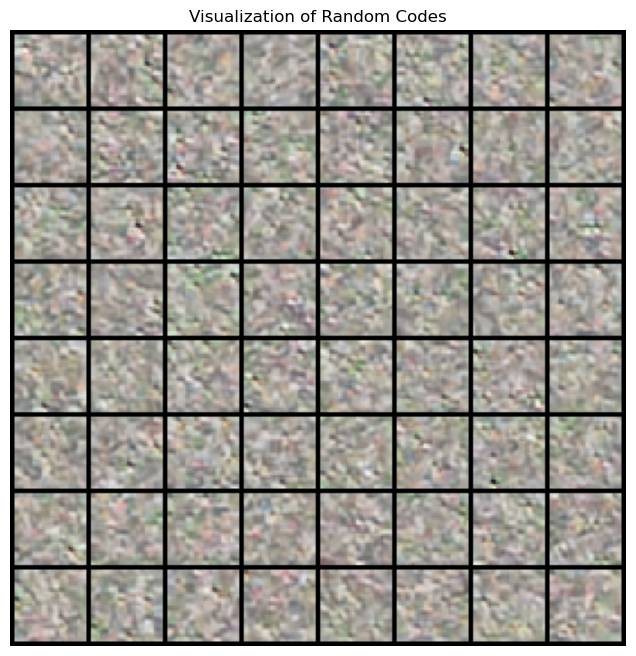

In [39]:
draw_random_sample_image(codebook, decoder, indices_shape=(batch_size//2, 8, 8))
